If time to event has the probability density function $f(t)$ and cumulative distribution function $F(t)$, then the probability of surviving at least to time $t$ is: $Pr(T>t)=S(t)=1-F(t)$. 

Cumulative hazard at time t is defined as $H(t)=-ln(S(t))$ and instantaneous hazard at time $t$ is $h(t)=\frac{dH(t)}{dt}$. The instantateous hazard can also be written as $h(t)=\frac{f(t)}{S(t)}$

The likelihood function for survival analysis is described as:

$$ l(\beta) = \prod_{n=1}^{n} h(t_{i})^{d_{i}} S(t_{i}) $$
where $d_i$ is the censoring variable that equals to 1 if the event is observed for individual $i$ and 0 if the event is not observed (censored) for individual $i$, $h(t_i)$ is the hazard for individual $i$ at time $t$, $H(t_i)$ is the cumulative hazard for individual $i$ at time $t$, and $S(t_i)$ is the survival probability for individual $i$ at time $t$. Note that when $d_i=0$, the contribution of the $i$'th individual to the likelihood function is just its survival probability until time $t$: S(t). If the individual has the event, the contribution to the likelihood function is given by the density function $f(t)=h(t)S(t)$.

The log of likelihood is:

$$ logl(\beta) = \sum_{i=1}^n d_i log(h(t_i)) - H(t_i) $$
where $log$ is the natural logarithm.

In [57]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from scipy.stats import norm
import statsmodels.api as st
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

#Lifelines is a survival analysis package
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test   
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [58]:
data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [60]:
data.Churn = labelencoder.fit_transform(data.Churn)
data.Churn.value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [61]:
## for survival analysis we need two elements (variables of interest)
# 1. Time to event (duration)
# 2. Event indicator (whether the event occurred)
# NOTE: timevar and eventvar will be extracted after data cleaning to ensure index alignment

In [62]:
# Convert TotalCharges to numeric (handle whitespace values)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

# Remove rows with missing values
data.dropna(inplace=True)

# Reset index after dropna to ensure consistency with all derived variables
data.reset_index(drop=True, inplace=True)

# Extract time and event variables with aligned indices
timevar = data["tenure"].reset_index(drop=True)
eventvar = data["Churn"].reset_index(drop=True)

# Create numeric target variable for correlation analysis (Yes=1, No=0)
data['Churn_Num'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

print("Dataset shape:", data.shape)
display(data.head())

Dataset shape: (7032, 22)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Num
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [63]:
#droping the CustomerID column as it is not useful for analysis
data.drop('customerID', axis=1, inplace=True)

In [64]:
categorical = data.select_dtypes(include=['object', 'category']).columns

survivaldata = pd.get_dummies(
    data,
    columns=categorical,
    drop_first=True
)

# Reset index to ensure alignment with timevar and eventvar
survivaldata.reset_index(drop=True, inplace=True)

survivaldata.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,Churn_Num,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,0,False,True,False,False,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,0,0,True,False,False,True,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,1,0,True,False,False,True,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,0,0,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,1,0,False,False,False,True,...,False,False,False,False,False,False,True,False,True,False


In [65]:
survivaldata.drop(['tenure', 'Churn'], axis = 1, inplace= True)
survivaldata = st.add_constant(survivaldata, prepend=False)
survivaldata.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Num,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,const
0,0,29.85,29.85,0,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,1.0
1,0,56.95,1889.50,0,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,1.0
2,0,53.85,108.15,0,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,1.0
3,0,42.30,1840.75,0,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,1.0
4,0,70.70,151.65,0,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,1.0


### Kaplan-Meier Survival Curves

The Kaplan–Meier method calculates the probability of survival at time $t$ as:

$$
S(t) = \prod_{i=1}^{t-1} \left(1 - \frac{d_i}{n_i}\right)
$$

where $S(t)$ is the probability of survival until time $t$, $d_i$ is the number of units that experienced the event at time $i$, and $n_i$ is the number of units at risk at time $i$.

This method is non-parametric and relies solely on observed event times and censoring information.

<img src="keplan.png" width="600"/>

**Figure:** Kaplan–Meier survival curve illustrating the estimated survival probability over time.


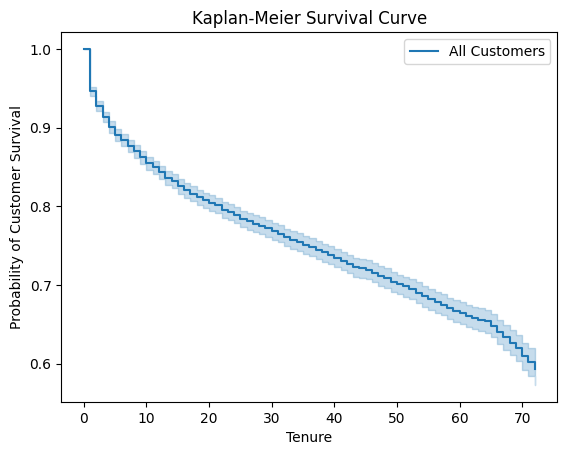

In [66]:
#initialising the kaplan meier fitter
kmf = KaplanMeierFitter()
#Calculate the K-M curve for all groups
kmf.fit(timevar,event_observed = eventvar,label = "All Customers")

kmf.plot()
plt.ylabel('Probability of Customer Survival')
plt.xlabel('Tenure')
plt.title('Kaplan-Meier Survival Curve');

At the beginning of the observation period, the survival probability is equal to one, indicating that all customers are initially active. A noticeable decline occurs within the early tenure period, suggesting that customer attrition is highest shortly after onboarding. This indicates the presence of early-stage churn, which may be associated with unmet expectations, pricing concerns, or service-related issues.

As tenure increases, the survival curve declines more gradually, implying that customers who remain beyond the initial periods exhibit a lower risk of churn. This pattern suggests that customer loyalty strengthens over time, and long-tenured customers are more likely to continue their subscription. Towards the later stages of tenure, the survival probability continues to decrease but at a slower rate, indicating relatively stable retention among long-standing customers.

The shaded confidence intervals around the survival curve reflect the uncertainty in the survival estimates. These intervals widen slightly at higher tenure values, which is expected due to the reduced number of customers at risk as time progresses. Overall, the Kaplan–Meier analysis highlights that customer churn risk is time-dependent, with the highest risk occurring early in the customer lifecycle.

### LOG RANK

We use the non-parametric log-rank test to compare survival curves across different groups. The test assumes that the hazard functions of the groups are proportional over time. Under the null hypothesis, the probability of experiencing the event is identical across all groups at every time point.

To evaluate the null hypothesis, the log-rank test computes the difference between the observed number of events and the expected number of events in each group. The expected number of events is calculated proportionally based on the number of individuals at risk in each group at the time an event occurs. These differences are aggregated over all observed event times. The log-rank test statistic for group $j$ ($k_j$) follows a $\chi^2$ distribution and is defined as:

$$k_j = \frac{(O_j - E_j)^2}{\text{var}(O_j - E_j)}$$

where $O_j - E_j$ is computed as:

$$O_j - E_j = \sum_{i} (o_{ij} - e_{ij})$$

and $\text{var}(O_j - E_j)$ is given by:

$$\text{var}(O_j - E_j) = \sum_i \frac{o_i \cdot n_{ij}}{n_i} \left(1 - \frac{n_{ij}}{n_i}\right) \frac{(n_i - o_i)}{(n_i - 1)}$$

Here, $o_{ij}$ denotes the observed number of events in group $j$ at time $i$, and $e_{ij}$ represents the expected number of events in group $j$ at time $i$, which is calculated as $e_{ij} = \frac{n_{ij}}{n_i} \cdot o_i$. The term $\frac{n_{ij}}{n_i}$ corresponds to the proportion of individuals in group $j$ who are at risk of experiencing the event at time $i$, where $n_{ij}$ is the number of individuals at risk in group $j$, $n_i$ is the total number of individuals at risk across all groups at time $i$, and $o_i$ is the total number of observed events at that time.

In [67]:
Survival_df = data.copy()
Survival_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_Num
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,No,One year,No,Mailed check,56.95,1889.50,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0


In [68]:
Survival_df.drop(['tenure', 'Churn'], axis = 1, inplace= True)
Survival_df = st.add_constant(Survival_df, prepend=False)
Survival_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn_Num,const
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1.0
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,0,1.0
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1.0
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,0,1.0


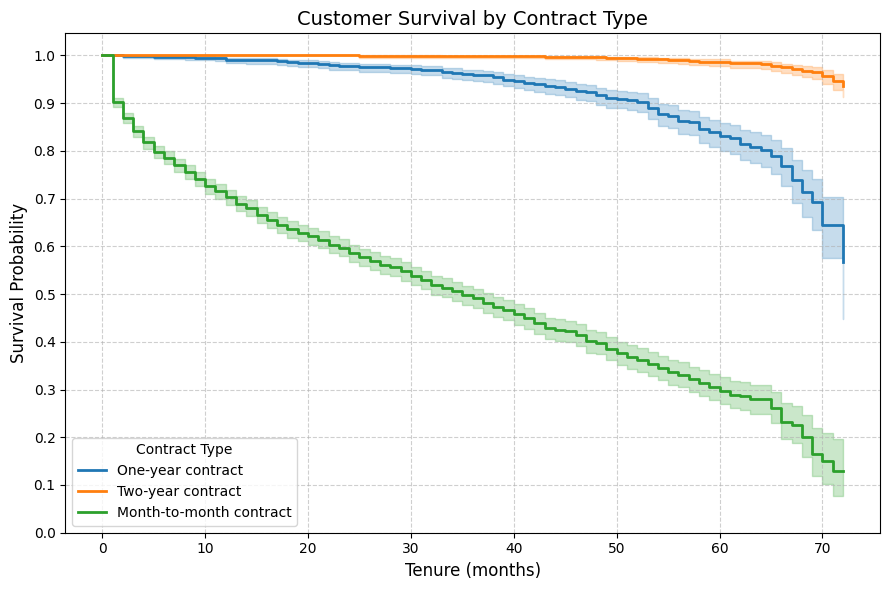

In [69]:
# Contract analysis by contract type
# Create boolean masks for filtering by contract type
contract_one_year = survivaldata['Contract_One year'] == 1
contract_two_year = survivaldata['Contract_Two year'] == 1
contract_month_to_month = (
    (survivaldata['Contract_One year'] == 0) &
    (survivaldata['Contract_Two year'] == 0)
)

# Create figure
plt.figure(figsize=(9, 6))
ax = plt.gca()

# One-year contract
kmf.fit(
    timevar[contract_one_year],
    event_observed=eventvar[contract_one_year],
    label="One-year contract"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Two-year contract
kmf.fit(
    timevar[contract_two_year],
    event_observed=eventvar[contract_two_year],
    label="Two-year contract"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Month-to-month contract
kmf.fit(
    timevar[contract_month_to_month],
    event_observed=eventvar[contract_month_to_month],
    label="Month-to-month contract"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Formatting
plt.title("Customer Survival by Contract Type", fontsize=14)
plt.xlabel("Tenure (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Contract Type", fontsize=10)

plt.tight_layout()
plt.show()

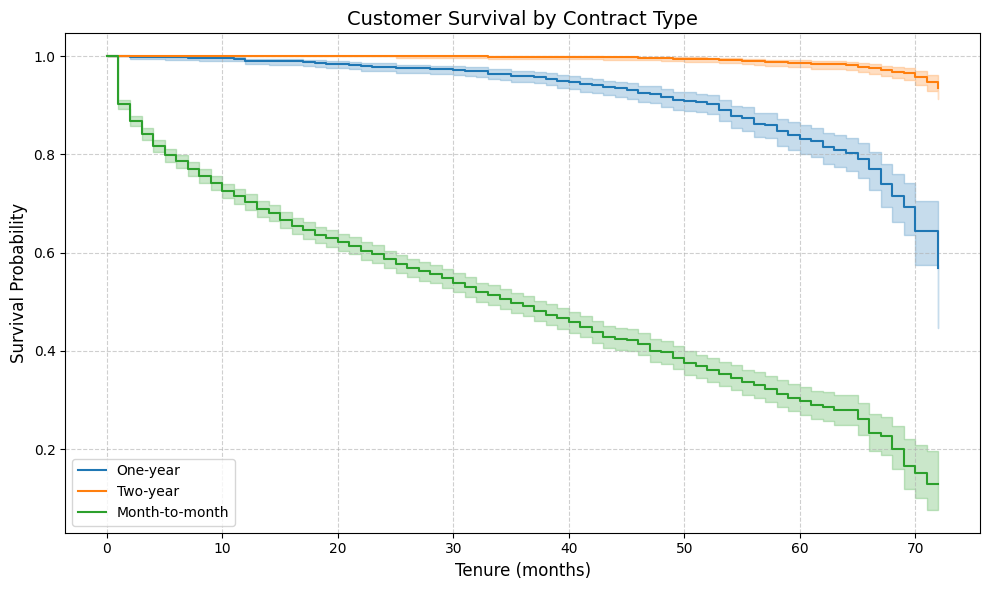

In [70]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

kmf1 = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()
kmf3 = KaplanMeierFitter()

kmf1.fit(timevar[contract_one_year], eventvar[contract_one_year], label="One-year")
kmf2.fit(timevar[contract_two_year], eventvar[contract_two_year], label="Two-year")
kmf3.fit(timevar[contract_month_to_month], eventvar[contract_month_to_month], label="Month-to-month")

kmf1.plot_survival_function(ax=ax, ci_show=True)
kmf2.plot_survival_function(ax=ax, ci_show=True)
kmf3.plot_survival_function(ax=ax, ci_show=True)

plt.title("Customer Survival by Contract Type", fontsize=14)
plt.xlabel("Tenure (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

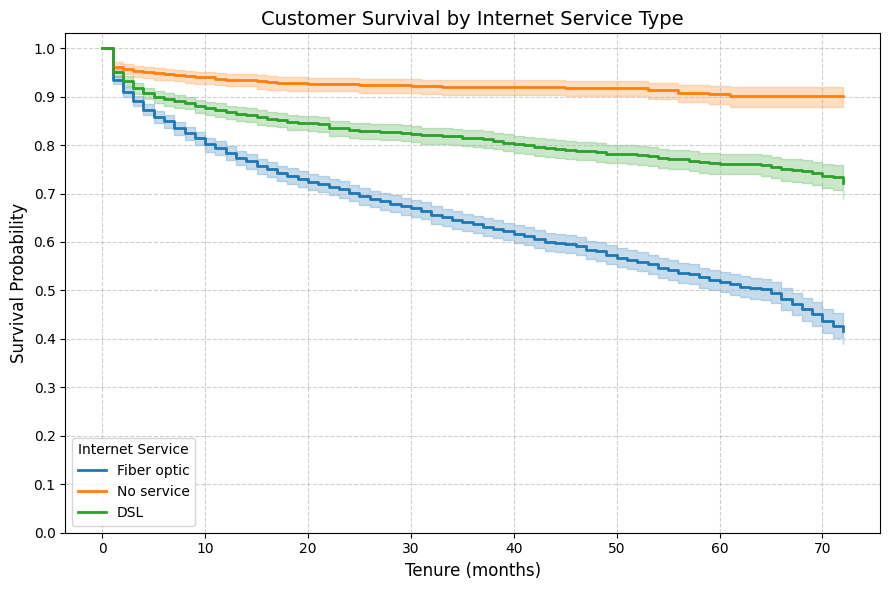

In [71]:

# Internet service groups
fiber_optic = survivaldata['InternetService_Fiber optic'] == 1
no_service = survivaldata['InternetService_No'] == 1
dsl = (
    (survivaldata['InternetService_Fiber optic'] == 0) &
    (survivaldata['InternetService_No'] == 0)
)

# Create figure
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Fiber optic
kmf.fit(
    timevar[fiber_optic],
    event_observed=eventvar[fiber_optic],
    label="Fiber optic"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# No service
kmf.fit(
    timevar[no_service],
    event_observed=eventvar[no_service],
    label="No service"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# DSL
kmf.fit(
    timevar[dsl],
    event_observed=eventvar[dsl],
    label="DSL"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Formatting
plt.title("Customer Survival by Internet Service Type", fontsize=14)
plt.xlabel("Tenure (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Internet Service", fontsize=10)

plt.tight_layout()
plt.show()

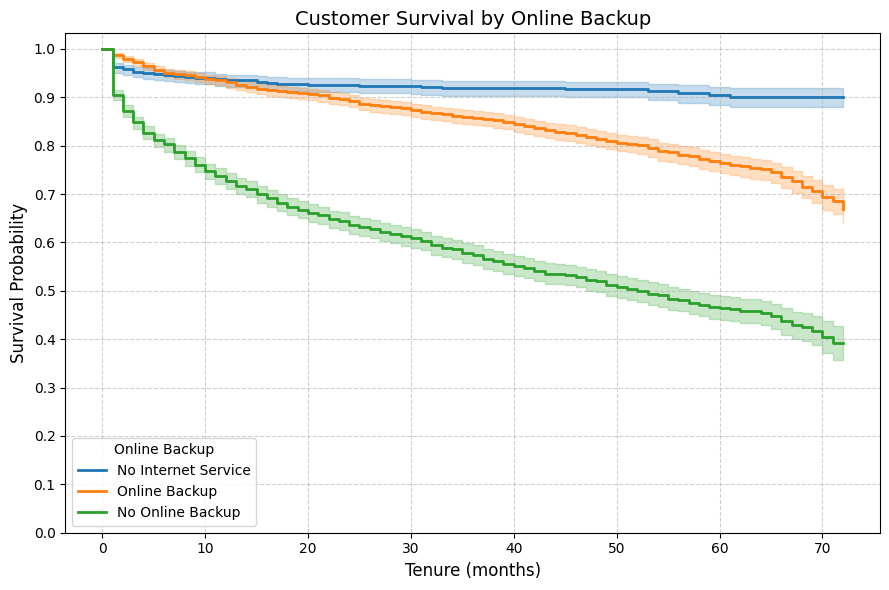

In [72]:
# Online backup groups
no_internet_service = survivaldata['OnlineBackup_No internet service'] == 1
online_backup = survivaldata['OnlineBackup_Yes'] == 1
no_online_backup = (
    (survivaldata['OnlineBackup_No internet service'] == 0) &
    (survivaldata['OnlineBackup_Yes'] == 0)
)

# Create figure
plt.figure(figsize=(9, 6))
ax = plt.gca()

# No Internet Service
kmf.fit(
    timevar[no_internet_service],
    event_observed=eventvar[no_internet_service],
    label="No Internet Service"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Online Backup
kmf.fit(
    timevar[online_backup],
    event_observed=eventvar[online_backup],
    label="Online Backup"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# No Online Backup
kmf.fit(
    timevar[no_online_backup],
    event_observed=eventvar[no_online_backup],
    label="No Online Backup"
)
kmf.plot_survival_function(
    ax=ax,
    ci_show=True,
    linewidth=2
)

# Formatting
plt.title("Customer Survival by Online Backup", fontsize=14)
plt.xlabel("Tenure (months)", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Online Backup", fontsize=10)
plt.tight_layout()
plt.show()


##### REGRESSION

In [75]:
def prepare_telco_df(df):
    """
    Preprocesses the Telco Customer Churn DataFrame.

    Args:
        df (pd.DataFrame): Raw Telco customer churn DataFrame.

    Returns:
        pd.DataFrame: Cleaned and preprocessed DataFrame ready for modeling.
    """
    
    # Drop unnecessary columns
    if 'customerID' in df.columns:
        df = df.drop('customerID', axis=1)
    
    # Convert TotalCharges to numeric and fill missing values
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'] = df['TotalCharges'].fillna(0)
    
    # Binary encoding for Yes/No columns
    binary_cols = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
    df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)
    
    # Encode gender
    df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})
    
    # Encode MultipleLines
    df['MultipleLines'] = df['MultipleLines'].map({'No phone service': 0, 'No': 0, 'Yes': 1})
    
    # Encode service-related columns
    service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                    'TechSupport', 'StreamingTV', 'StreamingMovies']
    df[service_cols] = df[service_cols].applymap(lambda x: 1 if x == 'Yes' else 0)
    
    # One-hot encode categorical columns
    categorical_cols = ['InternetService', 'Contract', 'PaymentMethod']
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    
    return df

In [76]:
reg_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
reg_data = reg_data.drop(['customerID'], axis=1) 
reg_data_clean = prepare_telco_df(reg_data)
print(reg_data_clean.head())


   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       1              0        1           0       1             0   
1       0              0        0           0      34             1   
2       0              0        0           0       2             1   
3       0              0        0           0      45             0   
4       1              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   MonthlyCharges  TotalCharges  Churn  InternetService_Fiber optic  \
0           29.85         29.85      0                        F

C:\Users\blessy\AppData\Local\Temp\ipykernel_4236\3914834618.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)
C:\Users\blessy\AppData\Local\Temp\ipykernel_4236\3914834618.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[service_cols] = df[service_cols].applymap(lambda x: 1 if x == 'Yes' else 0)


In [77]:
cph = CoxPHFitter()
cph.fit(reg_data_clean, duration_col='tenure', event_col='Churn')

cph.print_summary()

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -12659.69
         time fit was run = 2026-01-01 23:25:46 UTC

---
                                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                              
gender                                 0.04      1.04      0.05           -0.05            0.13                0.95                1.14
SeniorCitizen                          0.03      1.04      0.06           -0.08            0.15                0.93                1.16
Partner                               -0.18      0.84      0.06           -0.29           -0.07                0.75                0.93
Dependents                            -0.09      0.91      0.07           -0.23            0.05                0.80                1.05
PhoneService                           0.83      2.29      0.47           -0.10            1.76                0.90                5.80
MultipleLines                          0.09      1.09      0.13           -0.16            0.33                0.85                1.40
OnlineSecurity                        -0.21      0.81      0.13           -0.47            0.05                0.62                1.05
OnlineBackup                          -0.06      0.95      0.13           -0.31            0.19                0.74                1.21
DeviceProtection                       0.09      1.09      0.13           -0.16            0.34                0.85                1.40
TechSupport                           -0.08      0.92      0.13           -0.34            0.17                0.71                1.19
StreamingTV                            0.28      1.32      0.24           -0.18            0.74                0.83                2.10
StreamingMovies                        0.29      1.33      0.24           -0.18            0.75                0.84                2.11
PaperlessBilling                       0.15      1.16      0.06            0.04            0.26                1.04                1.30
MonthlyCharges                         0.01      1.01      0.02           -0.03            0.06                0.97                1.06
TotalCharges                          -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
InternetService_Fiber optic            1.02      2.77      0.58           -0.12            2.15                0.89                8.59
InternetService_No                    -2.34      0.10      0.60           -3.51           -1.17                0.03                0.31
Contract_One year                     -1.27      0.28      0.10           -1.46           -1.07                0.23                0.34
Contract_Two year                     -3.70      0.02      0.20           -4.10           -3.31                0.02                0.04
PaymentMethod_Credit card (automatic) -0.01      0.99      0.09           -0.19            0.17                0.83                1.18
PaymentMethod_Electronic check         0.39      1.47      0.07            0.24            0.53                1.28                1.70
PaymentMethod_Mailed check             0.51      1.67      0.09            0.34            0.68                1.40                1.98

                                       cmp to      z      p  -log2(p)
covariate                                                            
gender                                   0.00   0.85   0.40      1.33
SeniorCitizen                            0.00   0.61   0.54      0.88
Partner                                  0.00  -3.23 <0.005      9.67
Dependents          

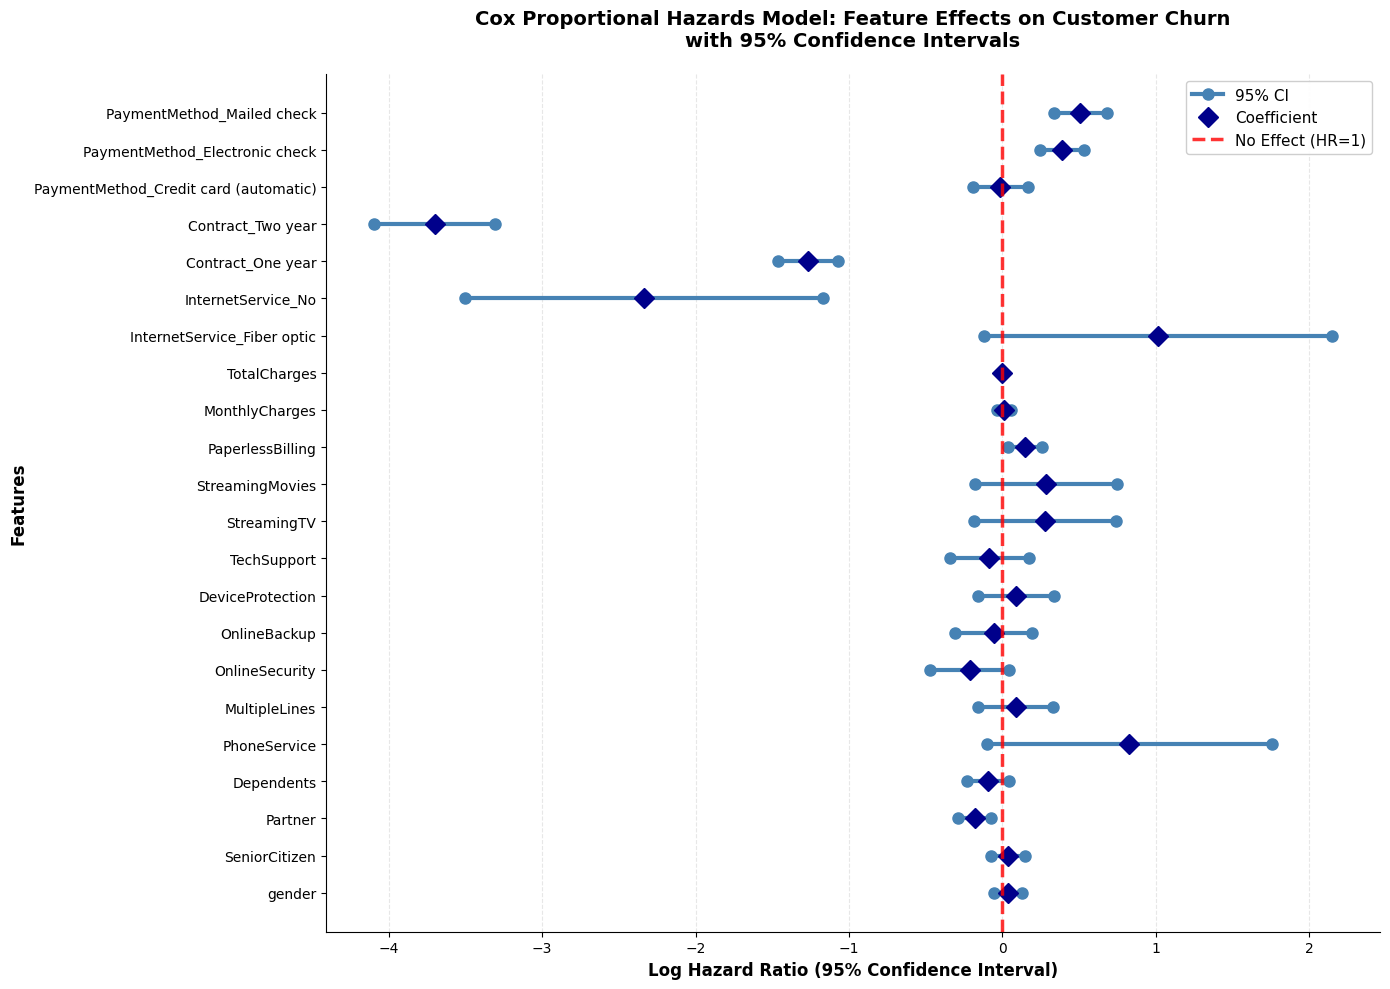


COX PROPORTIONAL HAZARDS MODEL - DETAILED SUMMARY

Concordance Index: 0.9286
  (Interpretation: Model predicts 92.86% of survival outcomes correctly)

Feature Effects with 95% Confidence Intervals:
------------------------------------------------------------------------------------------
                                       Coefficient  Exp(Coef)  95% CI Lower  95% CI Upper  Std. Error
covariate                                                                                            
gender                                    0.039404   1.040191     -0.051892      0.130700    0.046580
SeniorCitizen                             0.034453   1.035053     -0.076426      0.145333    0.056572
Partner                                  -0.177998   0.836944     -0.285909     -0.070087    0.055057
Dependents                               -0.091525   0.912539     -0.228362      0.045312    0.069816
PhoneService                              0.828169   2.289124     -0.101240      1.757578    0.474

In [81]:
# Create a more visually appealing Cox Proportional Hazards plot with confidence intervals
fig, ax = plt.subplots(figsize=(14, 10))

# Extract coefficients and confidence intervals
coef = cph.params_
ci = cph.confidence_intervals_
lower_ci = ci.iloc[:, 0]
upper_ci = ci.iloc[:, 1]

# Create y-axis positions
y_pos = np.arange(len(coef))

# Plot confidence intervals as filled areas
for i, (idx, coef_val) in enumerate(coef.items()):
    ax.plot([lower_ci[idx], upper_ci[idx]], [i, i], 'o-', linewidth=3, 
            markersize=8, color='steelblue', label='95% CI' if i == 0 else '')
    ax.plot(coef_val, i, 'D', markersize=10, color='darkblue', label='Coefficient' if i == 0 else '')

# Add vertical line at x=0 (no effect)
ax.axvline(x=0, color='red', linestyle='--', linewidth=2.5, alpha=0.8, label='No Effect (HR=1)')

# Set labels and formatting
ax.set_yticks(y_pos)
ax.set_yticklabels(coef.index, fontsize=10)
ax.set_xlabel("Log Hazard Ratio (95% Confidence Interval)", fontsize=12, fontweight='bold')
ax.set_ylabel("Features", fontsize=12, fontweight='bold')
ax.set_title("Cox Proportional Hazards Model: Feature Effects on Customer Churn\nwith 95% Confidence Intervals", 
             fontsize=14, fontweight='bold', pad=20)

# Improve grid and styling
ax.grid(True, axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
ax.legend(fontsize=11, loc='best', framealpha=0.95)

# Adjust layout
plt.tight_layout()
plt.show()

# Print detailed model summary with confidence intervals
print("\n" + "="*90)
print("COX PROPORTIONAL HAZARDS MODEL - DETAILED SUMMARY")
print("="*90)
print(f"\nConcordance Index: {cph.concordance_index_:.4f}")
print(f"  (Interpretation: Model predicts {cph.concordance_index_*100:.2f}% of survival outcomes correctly)\n")
print("Feature Effects with 95% Confidence Intervals:")
print("-" * 90)

# Create summary table
summary_df = pd.DataFrame({
    'Coefficient': cph.params_,
    'Exp(Coef)': np.exp(cph.params_),
    '95% CI Lower': lower_ci,
    '95% CI Upper': upper_ci,
    'Std. Error': cph.standard_errors_
})

print(summary_df.to_string())
print("-" * 90)
print("\nInterpretation Guide:")
print("  • Exp(Coef) > 1: Feature increases churn risk (shifts survival curve downward)")
print("  • Exp(Coef) < 1: Feature decreases churn risk (shifts survival curve upward)")
print("  • 95% CI does not contain 1.0: Feature has statistically significant effect (p < 0.05)")
print("="*90)